## import Packages

In [1]:
import requests
import os
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
today = pd.Timestamp.today().strftime('%Y-%m-%d')
print(today)

2023-11-15


## import Key

In [3]:
API_KEY = os.getenv('API_KEY')  # Replace with your actual API key

## List Sensors /ListSensors - Summary Data

#### This call returns the meta-data for all Breathe London Nodes on the network as an array of JSON objects. An example object is shown below.

In [4]:
API_LS = "https://api.breathelondon.org/api/ListSensors"

In [5]:
def get_sensors():
    try:
        # Construct the URL with the API key as a query parameter
        url = f"{API_LS}?key={API_KEY}"

        # Make the GET request
        response = requests.get(url)
        # Check for a successful response
        if response.status_code == 200:
            sensors = response.json()
            sensors = sensors[0]
            df_summary = pd.DataFrame(sensors)
            return df_summary
        
        # Handle potential errors
        elif response.status_code == 404:
            print("Error: Sensors not found.")
            return None
        else:
            print(f"Error {response.status_code}: {response.text}")
            return None
    
    except requests.RequestException as e:
        print(f"Error: {e}")
        return None

if __name__ == "__main__":
    df_summary = get_sensors()
    if df_summary is not None:
        df_summary.head()
    else:
        print("Failed to retrieve sensors.")

data = df_summary
## remove any empty strings or null values from SiteClassification
df_summary = df_summary[~df_summary['SiteClassification'].isin(['', None])]
df_summary['SiteName'] = df_summary['SiteName'].str.strip().str.lower()

all_sitecodes = df_summary[(df_summary['SiteActive'] == 1) & (df_summary['SiteClassification'].notnull()) & (df_summary['Enabled'] != 'N')]['SiteCode'].unique()
'''GENERATE THE SUMMARY DATASET'''
df_summary.to_csv('breathe_london_summary_data.csv', index=False)

#### Filtering the dataset by the sitenames that the team is interested in and use the sitecodes of this sites to get hourly data

In [6]:
# site_details = [RM13 9XD – Harris Academy
# RM13 9NZ – Rainham Against Pollution (Orchard Ave)
# RM13 9LJ – Rainham (reference co-location)
# RM13 9SA – Kind Edwards Ave, Rainham
# RM13 9SS – Spring Farm Park
# RM13 9TA – Acer Avenue, Rainham
# RM13 9FL Ingrebourne Links Golf  and Country Club ]

In [7]:
site_names_selected = [
    "Spring farm park", 
    "King Edwards Ave, Rainham",
    "Harris academy Rainham",
    "Rainham against pollution (Orchard Ave)",
    "Rainham (reference co-location)",
    "Acer Avenue, Rainham",
    "ingrebourne links golf  and country club"
]
site_names_selected = [x.lower() for x in site_names_selected]

df_selected_sites = df_summary[df_summary.SiteName.isin(site_names_selected)]

## get selected_sitecodes
selected_sitecodes = df_selected_sites[(df_selected_sites['SiteActive'] == 1) & (df_selected_sites['SiteClassification'].notnull()) & (df_selected_sites['Enabled'] != 'N')]['SiteCode'].unique()
selected_sitecodes = list(selected_sitecodes)
print(selected_sitecodes)
print(df_selected_sites[(df_selected_sites['SiteActive'] == 1) & (df_selected_sites['SiteClassification'].notnull())]['SiteCode'].nunique())

df_selected_sites.head()

['CLDP0025', 'CLDP0360', 'CLDP0361', 'CLDP0492', 'CLDP0501', 'CLDP0502', 'CLDP0517']
7


,SiteCode,SiteName,Latitude,Longitude,LocalAuthorityID,SiteClassification,HeadHeight,ToRoad,SiteLocationType,Indoor,SitePhotoURL,SiteDescription,SleepTime,BatteryStatus,BatteryPercentage,SignalStrength,SensorsHealthStatus,OverallStatus,DeviceCode,StartDate,EndDate,LastCommunication,InputPowerError,InputPowerCurrent,InputPowerVoltage,InputBatteryError,InputBatteryVoltage,ChargingStatus,SignalQuality,BatterySleepMultiplier,WeatherError,PMError,NO2Error,LatestINO2Value,LatestINO2Index,LatestINO2IndexSource,LatestIPM10Value,LatestIPM10NUMValue,LatestIPM1Value,LatestIPM1NUMValue,LatestIPM25Value,LatestIPM25Index,LatestIPM25IndexSource,LatestIPM25NUMValue,LatestRELHUMValue,LatestTEMPERATValue,SiteActive,SiteGroup,PowerTag,Enabled,OtherTags,OrganisationName,SponsorName,HourlyBulletinEnd
23,CLDP0025,rainham (reference co-location),51.520786,0.205461,None,Roadside,2.60,8.000000,Co-Location,0,https://api.breathelondon.org/assets/images/CL...,This is one of around twenty Breathe London re...,300.0,fully charged,99.0,4-excellent,OK,healthy,AQQ4MDXH,2023-08-01T10:00:00.000Z,None,2023-11-15T12:15:34.270Z,0,103,5.204781,0,4.150482,4,31,1,0,0,0,NaN,NaN,None,None,None,None,None,NaN,NaN,None,None,None,None,1,GLA,Mains,Y,"Deployed, GLA, Havering, Launders Lane, Mains3...",Mayor of London,Mayor of London,Nov 15 2023 11:00AM
344,CLDP0360,"acer avenue, rainham",51.520885,0.217450,None,Urban Background,2.35,17.700001,None,0,None,This Node is part of a small network being dep...,300.0,charging,99.0,4-excellent,OK,healthy,A9RNFBHT,2022-10-21T09:19:09.090Z,None,2023-11-15T10:52:31.613Z,0,6,22.413832,0,4.158210,2,29,1,0,0,0,12.0,1.0,Measurement,None,None,None,None,0.0,1.0,Measurement,None,None,None,1,Havering - Launders lane,Solar,Y,"Deployed, Havering, Launders Lane, Phase 1, So...",Havering,Havering,Nov 15 2023 11:00AM
345,CLDP0361,"king edwards ave, rainham",51.522743,0.214534,None,Urban Background,2.85,30.000000,None,0,None,This Node is part of a small network being dep...,300.0,charging,97.0,4-excellent,OK,healthy,AHZPHD60,2022-10-21T10:24:08.383Z,None,2023-11-15T11:22:47.150Z,0,4,22.194492,0,4.031224,2,25,1,0,0,0,19.0,1.0,Measurement,None,None,None,None,1.0,1.0,Measurement,None,None,None,1,Havering - Launders lane,Solar,Y,"Deployed, Havering, Launders Lane, Phase 1, So...",Havering,Havering,Nov 15 2023 11:00AM
476,CLDP0492,harris academy rainham,51.515007,0.205526,None,Urban Background,4.50,126.000000,School,0,https://upload-service-uploads-prd.s3.amazonaw...,This Node is part of a small network being dep...,NaN,charging,98.0,4-excellent,OK,healthy,ARNC37XL,2023-07-19T10:58:53.150Z,None,2023-11-15T09:19:51.653Z,0,8,22.712330,0,4.067396,2,31,1,0,0,0,NaN,NaN,None,None,None,None,None,NaN,NaN,None,None,None,None,1,Havering - Launders lane,Solar,Y,"Deployed, Havering, Launders Lane, Met Module,...",Havering,Havering,Nov 15 2023 11:00AM
485,CLDP0501,ingrebourne links golf and country club,51.512596,0.222102,None,Urban Background,2.20,44.000000,None,0,https://upload-service-uploads-prd.s3.amazonaw...,This Node is part of a small network being dep...,NaN,fully charged,98.0,4-excellent,OK,healthy,A3XKMKN7,2023-07-25T12:11:53.577Z,None,2023-11-15T10:11:39.347Z,0,4,22.710682,0,4.094332,4,27,1,0,0,0,NaN,NaN,None,None,None,None,None,NaN,NaN,None,None,None,None,1,Havering - Launders lane,Solar,Y,"Deployed, Havering, Launders Lane, Phase 2, So...",Havering,Havering,Nov 15 2023 11:00AM


In [52]:
print(', '.join(selected_sitecodes))

CLDP0025, CLDP0360, CLDP0361, CLDP0492, CLDP0501, CLDP0502, CLDP0517


In [8]:
df_selected_sites.groupby(['SiteName','SiteCode']).agg({'OrganisationName': 'unique', 'OtherTags':'unique'})

,,OrganisationName,OtherTags
SiteName,SiteCode,,
"acer avenue, rainham",CLDP0360,[Havering],"[Deployed, Havering, Launders Lane, Phase 1, S..."
harris academy rainham,CLDP0492,[Havering],"[Deployed, Havering, Launders Lane, Met Module..."
ingrebourne links golf and country club,CLDP0501,[Havering],"[Deployed, Havering, Launders Lane, Phase 2, S..."
"king edwards ave, rainham",CLDP0361,[Havering],"[Deployed, Havering, Launders Lane, Phase 1, S..."
rainham (reference co-location),CLDP0025,[Mayor of London],"[Deployed, GLA, Havering, Launders Lane, Mains..."
rainham against pollution (orchard ave),CLDP0517,[Rainham Against Pollution],"[Community Programme, Deployed, Havering, Laun..."
spring farm park,CLDP0502,[Havering],"[Deployed, Havering, Launders Lane, Phase 2, S..."


## Clarity Data /getClarityData

### About getClarityData 
<br/> https://www.globalcleanair.org/wp-content/blogs.dir/95/files/2021/05/BL-Pilot-Final-Technical-Report.pdf <br/>
<br/>
Sensors: Air pollution monitoring networks. Each pod contains several air quality sensors that provide near real-time local air quality information.
    (Sensors overall average every 1-15 minutes)
    Sensors collect information in 10-second intervals.
    PM sensors operated 30-seconds in each minute.
<br/>
<br/> To extract the clarityData, Site Code : Needs to be used as a parameter  <br/>
<ul> 
Species Data (Pollutant Measures):  
    <li>IPM25: PM2.5 (Particular Matter, light-scattering optical particle counter) </li>
    <li>INO2 : NO2 (Nitrogen dioxide) in (µg/m3) </li>
    </ul>
<ul> Pollution Levels:
    <li>ScaledValue: This value for each species indicates pollution levels </li>

### Hourly Data Extraction

In [9]:
API_URL = "https://api.breathelondon.org/api/getClarityData/{siteCode}/{species}/{startTime}/{endTime}/{averaging}?key={apiKey}"

def get_clarity_data(siteCode, species, startTime, endTime, averaging):
    try:
    # Format the API URL with required parameters
        formatted_startTime = startTime.replace(" ", "%20")
        formatted_endTime = endTime.replace(" ", "%20")
        url = API_URL.format(siteCode=siteCode, species=species, startTime=formatted_startTime, endTime=formatted_endTime, averaging=averaging, apiKey=API_KEY)
    
        response = requests.get(url)
    
        # Check if request was successful
        if response.status_code == 200:
            sensors = response.json()
            sensors = pd.DataFrame.from_dict(sensors)
            return sensors
        else:
            print(f"Error with status code: {response.status_code}")
            print(response.text)
            return None
    
    except ValueError:
        print("Received an unexpected response:")
        print(response.text)
        return None

#### Use the summary data to get the overall average 

In [10]:
# Add sitecodes needed here
siteCodes = all_sitecodes  
species1 = "IPM25"
species2 = "INO2"
averaging = "Hourly"

# Calculate start and end times
endTime = datetime.now()  # Current time
startTime = endTime - timedelta(days=365)  # One month before current time

# Convert datetime objects to strings
endTime_str = endTime.strftime("%a %d %b %Y %H:%M:%S")
startTime_str = startTime.strftime("%a %d %b %Y %H:%M:%S")

df_list = []  # List to store data for each site code

for siteCode in siteCodes:
    # Get data for first species
    data1 = get_clarity_data(siteCode, species1, startTime_str, endTime_str, averaging)
    if data1 is not None and isinstance(data1, pd.DataFrame):
        print(f"Received data for {siteCode} and {species1}")
        data1['DateTime'] = pd.to_datetime(data1['DateTime'])
        data1['mod_datetime'] = data1['DateTime'] + pd.Timedelta(hours=1)
        data1['species'] = species1
        df_list.append(data1)  # Add the DataFrame to the list
    else:
        print(f"No data received for {siteCode} and {species1}")

    # Get data for second species
    data2 = get_clarity_data(siteCode, species2, startTime_str, endTime_str, averaging)
    if data2 is not None and isinstance(data2, pd.DataFrame):
        print(f"Received data for {siteCode} and {species2}")
        data2['DateTime'] = pd.to_datetime(data2['DateTime'])
        data2['mod_datetime'] = data2['DateTime'] + pd.Timedelta(hours=1)
        data2['species'] = species2
        df_list.append(data2)  # Add the DataFrame to the list
    else:
        print(f"No data received for {siteCode} and {species2}")

# Concatenate all DataFrames in the list
if df_list:
    df_all = pd.concat(df_list)
    # print(df.head())
else:
    print("No data received for all site codes and species.")

print(df_all.mod_datetime.max()), print(df_all.SiteCode.nunique(),print(df_all.shape))
df_all.head()


Received data for CLDP0001 and IPM25
Received data for CLDP0001 and INO2
Received data for CLDP0002 and IPM25
Received data for CLDP0002 and INO2
Received data for CLDP0003 and IPM25
Received data for CLDP0003 and INO2
Received data for CLDP0004 and IPM25
Received data for CLDP0004 and INO2
Received data for CLDP0005 and IPM25
Received data for CLDP0005 and INO2
Received data for CLDP0007 and IPM25
Received data for CLDP0007 and INO2
Received data for CLDP0008 and IPM25
Received data for CLDP0008 and INO2
Received data for CLDP0009 and IPM25
Received data for CLDP0009 and INO2
Received data for CLDP0010 and IPM25
Received data for CLDP0010 and INO2
Received data for CLDP0012 and IPM25
Received data for CLDP0012 and INO2
Received data for CLDP0013 and IPM25
Received data for CLDP0013 and INO2
Received data for CLDP0014 and IPM25
Received data for CLDP0014 and INO2
Received data for CLDP0015 and IPM25
Received data for CLDP0015 and INO2
Received data for CLDP0016 and IPM25
Received data 

,SiteCode,DateTime,DurationNS,ScaledValue,mod_datetime,species
0,CLDP0001,2022-11-15 13:00:00+00:00,3600000000,8.877676,2022-11-15 14:00:00+00:00,IPM25
1,CLDP0001,2022-11-15 14:00:00+00:00,3600000000,18.262876,2022-11-15 15:00:00+00:00,IPM25
2,CLDP0001,2022-11-15 15:00:00+00:00,3600000000,22.179064,2022-11-15 16:00:00+00:00,IPM25
3,CLDP0001,2022-11-15 17:00:00+00:00,3600000000,14.235772,2022-11-15 18:00:00+00:00,IPM25
4,CLDP0001,2022-11-15 18:00:00+00:00,3600000000,13.766512,2022-11-15 19:00:00+00:00,IPM25


In [26]:
df_all.to_csv('20231115_breathe_london_data_ALL.csv', index=False)

In [31]:
df_all.SiteCode.nunique()

415

In [11]:
overall_avg_im25 = df_all[df_all['species'] == 'IPM25']['ScaledValue'].mean()
print('Total Average of IM2.5 across all sites =', overall_avg_im25)
overall_avg_in02 = df_all[df_all['species'] == 'INO2']['ScaledValue'].mean()
print('Total Average of IN02 across all sites =', overall_avg_in02)

Total Average of IM2.5 across all sites = 8.754846857437082
Total Average of IN02 across all sites = 25.867323737145174


#### filter the df to show information only on selected sites

In [12]:
df = df_all[df_all['SiteCode'].isin(selected_sitecodes)]

In [13]:
## when the spices is IPM25 and the ScaledValue is 35 or above, create a new column called 'alert'
## when the spices is INO2 and the ScaledValue is 40 or above, create a new column called 'alert'
df["alert"] = df.apply(
    lambda x: "alert"
    if (x["species"] == "IPM25" and x["ScaledValue"] >= 15)
    or (x["species"] == "INO2" and x["ScaledValue"] >= 25)
    else "no alert",
    axis=1,
)
## get Date from DateTime
df['Date'] = df['mod_datetime'].dt.date
df.head()


,SiteCode,DateTime,DurationNS,ScaledValue,mod_datetime,species,alert,Date
0,CLDP0025,2022-11-15 12:00:00+00:00,3600000000,3.937861,2022-11-15 13:00:00+00:00,IPM25,no alert,2022-11-15
1,CLDP0025,2022-11-15 13:00:00+00:00,3600000000,4.509635,2022-11-15 14:00:00+00:00,IPM25,no alert,2022-11-15
2,CLDP0025,2022-11-15 14:00:00+00:00,3600000000,3.821053,2022-11-15 15:00:00+00:00,IPM25,no alert,2022-11-15
3,CLDP0025,2022-11-15 15:00:00+00:00,3600000000,4.495602,2022-11-15 16:00:00+00:00,IPM25,no alert,2022-11-15
4,CLDP0025,2022-11-15 16:00:00+00:00,3600000000,6.880843,2022-11-15 17:00:00+00:00,IPM25,no alert,2022-11-15


In [14]:
df.Date.max()

datetime.date(2023, 11, 15)

In [15]:
## save hourly data for the chosen sites here:
df.to_csv('../data_output/breathe_london_hourly_data.csv', index=False)

## Final df

In [16]:
## create a new column called 'month_year'
df['month_year'] = df['DateTime'].dt.strftime('%b-%Y')
df = df.merge(df_summary[['SiteCode', 'SiteName','OrganisationName','Latitude','Longitude']], on='SiteCode', how='left')
df['SiteName'] = df['SiteName'].str.capitalize()
df['date'] = df['DateTime'].dt.date

In [17]:
## taking the average value per day for each spices
df_main = df.groupby(['species','date']).agg({'ScaledValue':'mean', 'Latitude':'first', 'Longitude':'first'}).reset_index()
df_main.head()

,species,date,ScaledValue,Latitude,Longitude
0,INO2,2022-11-15,23.577675,51.520786,0.205461
1,INO2,2022-11-16,21.514853,51.520786,0.205461
2,INO2,2022-11-17,19.509987,51.520786,0.205461
3,INO2,2022-11-18,22.240211,51.520786,0.205461
4,INO2,2022-11-19,21.330288,51.520786,0.205461


In [18]:
df_main.to_csv('../data_output/breathe_london_data_main.csv', index=False)

### threshold information
- PM2.5 Daily (24 Hour) Average threshold is 15
- NO2 Daily (24 Hour) Average threshold 25

In [19]:
## when the spices is IPM25 and the ScaledValue is 35 or above, create a new column called 'alert'
## when the spices is INO2 and the ScaledValue is 40 or above, create a new column called 'alert'
df_main["alert"] = df_main.apply(
    lambda x: "alert"
    if (x["species"] == "IPM25" and x["ScaledValue"] >= 15)
    or (x["species"] == "INO2" and x["ScaledValue"] >= 25)
    else "no alert",
    axis=1,
)
df_main.head()

,species,date,ScaledValue,Latitude,Longitude,alert
0,INO2,2022-11-15,23.577675,51.520786,0.205461,no alert
1,INO2,2022-11-16,21.514853,51.520786,0.205461,no alert
2,INO2,2022-11-17,19.509987,51.520786,0.205461,no alert
3,INO2,2022-11-18,22.240211,51.520786,0.205461,no alert
4,INO2,2022-11-19,21.330288,51.520786,0.205461,no alert


In [20]:
'''Filter out the dataset to focus on only days where there was an alert'''
df_main_alert = df_main[df_main['alert'] == 'alert']
print(df_main_alert.shape)
'''Separting the alert dataset into two datasets, one for IPM25 and one for INO2'''
df_pm = df_main_alert[df_main_alert['species'] == 'IPM25']
df_no2 = df_main_alert[df_main_alert['species'] == 'INO2']
print(df_pm.shape), print(df_no2.shape)

(151, 6)
(42, 6)
(109, 6)


(None, None)

# get the average for the sites based on excel from Purpose

In [28]:
df_p = pd.read_excel('../AlteredByPurpose_breathe_london_summary_data.xlsx')
df_p_sites =df_p['SiteCode'].unique()
print(len(df_p_sites))


268


In [29]:
df_p = df_all[df_all['SiteCode'].isin(df_p_sites)]
print(df_p['SiteCode'].nunique())

229


In [30]:
overall_avg_im25_purpose_selected = df_p[df_p['species'] == 'IPM25']['ScaledValue'].mean()
print('Total Average of IM2.5 across all sites =', overall_avg_im25)
overall_avg_in02_purpose_selected = df_p[df_p['species'] == 'INO2']['ScaledValue'].mean()
print('Total Average of IN02 across all sites =', overall_avg_in02)

Total Average of IM2.5 across all sites = 8.754846857437082
Total Average of IN02 across all sites = 25.867323737145174


# TESTING: Get the average scaled value per site by species

In [48]:
def outliers(df, species):
    df = df[df['species'] == species].groupby(['SiteCode','species'])['ScaledValue'].mean().reset_index()
    df['ScaledValue'] = df['ScaledValue'].astype(int)
    return df
df_all_site_avg_ino2 = outliers(df_all, 'INO2')
df_all_site_avg_PM25 = outliers(df_all, 'IPM25')

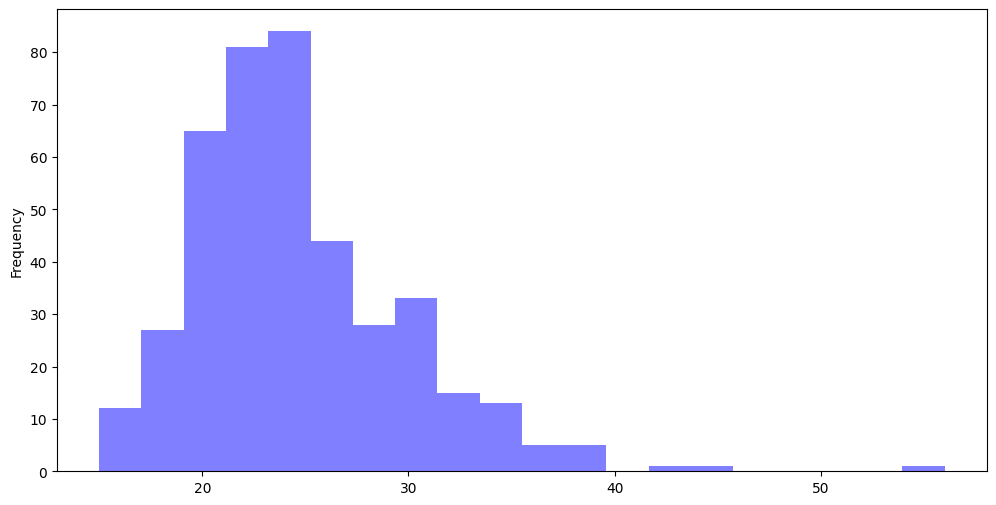

In [49]:
df_all_site_avg_ino2['ScaledValue'].plot(kind='hist', bins=20, figsize=(12,6), color='blue', alpha=0.5);
